In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge,Lasso,LinearRegression
from sklearn.model_selection import RandomizedSearchCV,train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [246]:
#load data
energy_data = pd.read_csv('energydata_complete.csv')

In [247]:
energy_data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [248]:
data_length = len(energy_data)
print('length of data : ', data_length)

length of data :  19735


In [249]:
# collect target
appliance_use = energy_data['Appliances']

#drop date and lights columns
energy_data.drop(columns=['date','lights'],inplace=True)

#Extract rv1 and rv2
rv1 = energy_data['rv1']
rv2 = energy_data['rv2']
#energy_data.isnull().sum()

In [253]:
# check for missing data
energy_data.isnull().sum()

Appliances     0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [250]:
# Map column names to their meanings.
columns = { 'Appliances' : 'energy use in Wh',
'T1' : 'Temperature in kitchen area, in Celsius',
'RH_1' : 'Humidity in kitchen area, in %',
 'T2'  : 'Temperature in living room area, in Celsius',
'RH_2' : 'Humidity in living room area, in %',
'T3' : 'Temperature in laundry room area',
'RH_3' : 'Humidity in laundry room area, in %',
'T4' : 'Temperature in office room, in Celsius',
'RH_4' : 'Humidity in office room, in %',
'T5' : 'Temperature in bathroom, in Celsius',
'RH_5' : 'Humidity in bathroom, in %',
'T6':  'Temperature outside the building (north side), in Celsius',
'RH_6' :  'Humidity outside the building (north side), in %',
'T7' : 'Temperature in ironing room , in Celsius',
'RH_7' : 'Humidity in ironing room, in %',
'T8' : 'Temperature in teenager room 2, in Celsius',
'RH_8': 'Humidity in teenager room 2, in %',
'T9' : 'Temperature in parents room, in Celsius',
'RH_9': 'Humidity in parents room, in %',
'T_out': 'Temperature outside (from Chievres weather station), in Celsius',
 'Press_mm_hg': '(from Chievres weather station), in mm Hg',
'RH_out': 'Humidity outside (from Chievres weather station), in %',
'Wind speed': '(from Chievres weather station), in m/s',
'Visibility' :'(from Chievres weather station), in km',
'Tdewpoint': '(from Chievres weather station), Â °C'}

In [252]:
len(energy_data.columns)

27

## Univariate analysis

In [254]:
from ipywidgets import interact
# Make an interactive boxplot for each feature.
@interact
def energy_box_plotter(columns = columns.keys()):
    energy_data[columns].plot(kind='box')

interactive(children=(Dropdown(description='columns', options=('Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',…

we see that data under each feature has skewness > 0 (majorly right-skewness) with long tails (outliers)
we will have to scale this dataset to reduce the skewness and amount of outliers. we are going to use the MinMaxScaler in this project.

## Bivariate Analysis

In [166]:
# Make an interactive plot between the features including the target variable (Appliances)
@interact
def plotter(column1=columns.keys() , column2= columns.keys()):
    print(energy_data[column2].corr(energy_data[column1]))
    plt.scatter(energy_data[column1],energy_data[column2])
    plt.xlabel(columns[column1])
    plt.ylabel(columns[column2])
    plt.grid(True)
    plt.title('Bivariate analysis')
    plt.show()

interactive(children=(Dropdown(description='column1', options=('Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',…

Now let's scale our dataset with the MinMaxScaler.

In [321]:
# scale data using minmaxscaler.
scaler = MinMaxScaler()
transformed_data = scaler.fit_transform(energy_data)

In [322]:
#transform data back into a dataframe for table visualization
transformed_data  = pd.DataFrame(transformed_data, columns= energy_data.columns)
transformed_data.head()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,0.046729,0.32735,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,0.175506,...,0.223032,0.677290,0.372990,0.097674,0.894737,0.500000,0.953846,0.538462,0.265449,0.265449
1,0.046729,0.32735,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,0.175506,...,0.226500,0.678532,0.369239,0.100000,0.894737,0.476190,0.894872,0.533937,0.372083,0.372083
2,0.037383,0.32735,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,0.175506,...,0.219563,0.676049,0.365488,0.102326,0.894737,0.452381,0.835897,0.529412,0.572848,0.572848
3,0.037383,0.32735,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,0.175506,...,0.219563,0.671909,0.361736,0.104651,0.894737,0.428571,0.776923,0.524887,0.908261,0.908261
4,0.046729,0.32735,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,0.178691,...,0.219563,0.671909,0.357985,0.106977,0.894737,0.404762,0.717949,0.520362,0.201611,0.201611


In [323]:
#drop columns appliances , rv1 and rv2. rv1 and rv2 added very little contribution after using lasso.
data = transformed_data.drop(columns=['Appliances','rv1','rv2'])
appliance = transformed_data['Appliances']
X_train, x_test,y_train,y_test = train_test_split(data, appliance , test_size=0.3, random_state = 42)

## Examining correlation between features.
There are about 27 features in the dataset. Let's check out the correlation table to figure out which columns are dependent.

In [262]:
# Extract correlation table.
energy_data.corr()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
Appliances,1.000000,0.055447,0.086031,0.120073,-0.060465,0.085060,0.036292,0.040281,0.016965,0.019760,...,0.010010,-0.051462,0.099155,-0.034885,-0.152282,0.087122,0.000230,0.015353,-0.011145,-0.011145
T1,0.055447,1.000000,0.164006,0.836834,-0.002509,0.892402,-0.028550,0.877001,0.097861,0.885247,...,0.844777,0.071756,0.682846,-0.150574,-0.345481,-0.087654,-0.076210,0.571309,-0.006203,-0.006203
RH_1,0.086031,0.164006,1.000000,0.269839,0.797535,0.253230,0.844677,0.106180,0.880359,0.205797,...,0.115263,0.764001,0.340767,-0.293957,0.274126,0.204932,-0.021057,0.639106,-0.000699,-0.000699
T2,0.120073,0.836834,0.269839,1.000000,-0.165610,0.735245,0.121497,0.762066,0.231563,0.720550,...,0.675535,0.157346,0.792255,-0.133028,-0.505291,0.052495,-0.069721,0.582602,-0.011087,-0.011087
RH_2,-0.060465,-0.002509,0.797535,-0.165610,1.000000,0.137319,0.678326,-0.047304,0.721435,0.110409,...,0.054544,0.676467,0.033674,-0.255646,0.584911,0.069190,-0.005368,0.499152,0.006275,0.006275
T3,0.085060,0.892402,0.253230,0.735245,0.137319,1.000000,-0.011234,0.852778,0.122737,0.888169,...,0.901324,0.134602,0.699417,-0.189974,-0.281718,-0.100776,-0.102310,0.645886,-0.005194,-0.005194
RH_3,0.036292,-0.028550,0.844677,0.121497,0.678326,-0.011234,1.000000,-0.140457,0.898978,-0.050062,...,-0.195270,0.833538,0.118207,-0.233274,0.356192,0.263188,0.017041,0.414387,-0.000477,-0.000477
T4,0.040281,0.877001,0.106180,0.762066,-0.047304,0.852778,-0.140457,1.000000,-0.048650,0.871813,...,0.889439,-0.025549,0.663478,-0.075292,-0.388602,-0.185747,-0.104768,0.519471,-0.001815,-0.001815
RH_4,0.016965,0.097861,0.880359,0.231563,0.721435,0.122737,0.898978,-0.048650,1.000000,0.091812,...,-0.044518,0.856591,0.293289,-0.250748,0.336813,0.300192,0.002636,0.616509,-0.001787,-0.001787
T5,0.019760,0.885247,0.205797,0.720550,0.110409,0.888169,-0.050062,0.871813,0.091812,1.000000,...,0.911055,0.072308,0.651321,-0.170999,-0.273953,-0.145011,-0.084164,0.588362,-0.005490,-0.005490


## Feature selection

we immediately see that there is basically no correlation between each feature and the target variable (Appliance). Also, there is significant correlation between all the temperature columns and the relative humidity features as expected while the pressure,windspeed,visibility,tdewpoint showed no correlation between any of the features.
We face a challenge here. Removing the dependent features may hurt the predictive capability of our final model because we will endup with very few features. At the same time, leaving them may not add any value to the predictive model.
So, let's determine and order the features according to importance. we will create a function that iteratively calculates a cross-validation score as it drops the least important feature at each step. Then, we will plot a graph tracking the error loss as the number of features (after ordering) decreases.

First, we will calculate the best of features that cause the minimum error loss.


In [324]:
from sklearn.base import TransformerMixin

# Create a class that extracts the given features during initialization from the dataset.
class FeatureSelector(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        
    def fit(self,X,y=None):
        return self
    
    def transform(self, X,y=None):
        return X.loc[:,self.columns]
    


In [325]:
#gets a list of ordered feature names
def get_features(imp_features):
    feature_names = []
    for feature, score in imp_features:
        feature_names.append(feature)
    return feature_names

# Function to sort features in descending order according to value of their coefficients.
def sort_features(features, coef):
    imp_features = []
    for feature,coef in zip(features,coef):
        imp_features.append((feature,np.abs(coef))) # append feature with coefficient
    imp_features.sort(key=lambda x: x[1], reverse=True) # sort features
    feature_importance = get_features(imp_features) #get feature names in order of importance.
    return feature_importance

# function returns the best_features that cause the least amount of loss error.
def max_features():
    scores_cache = [15000] # set score to an arbitrary high number.
    features_cache = [] # list to store less important features.
    score = 0
    rgr = LinearRegression() # model that we will use to determined coefficients of the features.
    # list containing the will eventually contain the best features.  However, it is initialize to the columns of the dataset.d
    best_features = list(data.columns) 
    for i in range(0,len(data.columns)):
        feat_selector = FeatureSelector(best_features)
        x_train = feat_selector.fit_transform(X_train)
        #print('Performing cross-validation...')
        #calculate cross-validation score.
        score = np.abs(np.mean(cross_val_score(rgr,x_train,y_train,cv=5,scoring='neg_mean_squared_error')))
        #print(np.abs(score),min(scores_cache))
        if score < min(scores_cache):
        #if score < min(scores_cache):
            #print('Fitting data to the regressor...')
            #fit model to get coefficients of features
            rgr.fit(x_train,y_train)
            coefs = rgr.coef_
            #print('Sorting features....')
            #sort_features according to weights of the coefficients.
            best_features = sort_features(list(x_train.columns), coefs)
            #Append least iimportant feature to the features_cache list.
            features_cache.append(best_features.pop())
            #print(len(best_features))
            #append score.
            scores_cache.append(score)
        else:
            return best_features, scores_cache, features_cache
        
    return best_features, scores_cache , features_cache

In [326]:
best_features , scores_cache , features_cache = max_features()

In [327]:
print(best_features, f'\n Length of best_features : {len(best_features)}')
print(scores_cache)
print(features_cache)

['RH_1', 'RH_2', 'T_out', 'T3', 'T2', 'T6', 'T9', 'RH_8', 'Tdewpoint', 'T8', 'RH_3', 'RH_out', 'RH_7', 'RH_9', 'RH_6', 'Windspeed', 'T4', 'RH_4', 'T5', 'RH_5', 'Visibility', 'T7'] 
 Length of best_features : 22
[15000, 0.007957835590854136, 0.00795685542451403]
['T1', 'Press_mm_hg']


we see that 9109.8 is the lowest error attained by 22 features. T1 and 'Press_mm_hg' were the least important features in the dataset while RH1 and RH2 are the most important. However, models can more than one dips. so, lets iterately drop each features (according to their importance) and then, plot a graph showing the error_loss as we do so.

In [330]:

# function returns the best_features that cause the least amount of loss error.
def drop_features():
    scores_cache = [] 
    features_cache = [] # list to store less important features.
    rgr = LinearRegression() # model that we will use to determined coefficients of the features.
    # list containing the will eventually contain the best features.  However, it is initialize to the columns of the dataset.d
    best_features = list(data.columns) 
    for i in range(0,len(data.columns)):
        feat_selector = FeatureSelector(best_features)
        x_train = feat_selector.fit_transform(X_train)
        #print('Performing cross-validation...')
        #calculate cross-validation score.
        score = np.abs(np.mean(cross_val_score(rgr,x_train,y_train,cv=5,scoring='neg_mean_squared_error')))
        #print(np.abs(score),min(scores_cache))
        #if score < min(scores_cache):
        #print('Fitting data to the regressor...')
        #fit model to get coefficients of features
        rgr.fit(x_train,y_train)
        coefs = rgr.coef_
        #print('Sorting features....')
        #sort_features according to weights of the coefficients.
        best_features = sort_features(list(x_train.columns), coefs)
        #Append least iimportant feature to the features_cache list.
        best_features.pop()
        #print(len(best_features))
        #append score.
        scores_cache.append(score)


    return scores_cache 

In [331]:
scores_cache  = drop_features()

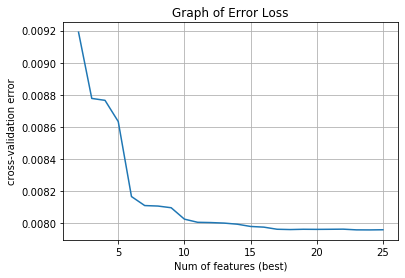

In [332]:
plt.plot(range(len(data.columns)+1,1,-1), scores_cache)
plt.xlabel('Num of features (best)')
plt.ylabel('cross-validation error')
plt.title('Graph of Error Loss')
plt.grid(True)
plt.show()

We see here that the error loss generally increased as we reduced the number of features in order of importance. We see a sharp rise after 10 best features

## Model selection
Lets spotcheck the major multiple linear regression models available to us to see which model does a better job.

In [333]:
models = {'ridge': Ridge(),'lasso': Lasso(),'rgr': LinearRegression()}
scores = []
def spot_check():
    for name, model in models.items():
        val_score = cross_val_score(model,X_train,y_train,cv=10, scoring='neg_mean_squared_error')
        score  = np.mean(val_score)
        scores.append((name,score))
        
spot_check()
for name, score in scores:
    print(name + '          --------------->', score)

ridge          ---------------> -0.007961723216595206
lasso          ---------------> -0.009260994142306241
rgr          ---------------> -0.007953340018472132


Here, we see that the linear regressor model and ridge model performed better than the Lasso model. I am going to pick the ridge model in this project because it offers a good tuning of its hyperparameter C. Here, I assume that the ridge model will eventually do better than the linear regression model in terms of reducing error loss.

We will also train two models. One on the full dataset containing all features and the second on the best features determined earlier.

In [334]:
param_grid = {'alpha': np.logspace(-2,-1,10)}
#ridge_model = Pipeline([('feat_selector',FeatureSelector(sel_features)),('ridge',Ridge())])
ridge_model = Ridge()
gridsearch = GridSearchCV(ridge_model, param_grid,scoring ='neg_mean_squared_error', cv=5,n_jobs=-1,verbose=1)
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([0.01      , 0.0129155 , 0.01668101, 0.02154435, 0.02782559,
       0.03593814, 0.04641589, 0.05994843, 0.07742637, 0.1       ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [335]:
print(gridsearch.best_score_)
print(gridsearch.best_params_)

-0.007957685710336492
{'alpha': 0.0774263682681127}


The best value for C is 0.077 as we can see here. Let's extract the best estimator and determine the cross validation score.

In [336]:
best_ridge = gridsearch.best_estimator_
mean_score = np.mean(cross_val_score(best_ridge,X_train,y_train,cv=10,scoring= 'neg_mean_squared_error'))
print(mean_score)

-0.007953257417296095


we see that the best ridge model performed at the same level as the linear regression model used to spotcheck above. Let's check out the performance on the test set.

In [337]:
from sklearn.metrics import mean_squared_error as mse
mse(y_test, best_ridge.predict(x_test))

0.007656433679104752

The testing error (0.0076) was lower than the training error (0.00795), hinting a low variance and bias by this tuned ridge model. Let's train and tune a ridge model on the best features now and see how well the model does.

In [338]:
param_grid = {'ridge__alpha': np.logspace(-3,-1,20)}
ridge_pipe = Pipeline([('feat_selector',FeatureSelector(best_features)),('ridge',Ridge())])
#ridge_model = Ridge()
gridsearch_pipe = GridSearchCV(ridge_pipe, param_grid,scoring ='neg_mean_squared_error', cv=5,n_jobs=-1,verbose=1)
gridsearch_pipe.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('feat_selector',
                                        <__main__.FeatureSelector object at 0x000002910114E2C8>),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'ridge__alpha': array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
       0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
       0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
       0.0379269 , 0.0483293 

In [339]:
print(gridsearch_pipe.best_params_)
print(gridsearch_pipe.best_score_)

{'ridge__alpha': 0.07847599703514611}
-0.007957047792027685


In [340]:
best_estimator = gridsearch.best_estimator_
mean_score = np.mean(cross_val_score(best_estimator,X_train,y_train,cv=10,scoring= 'neg_mean_squared_error'))
print(mean_score)

-0.007953257417296095


In [341]:
ridge_pipe= gridsearch.best_estimator_
mse(y_test, ridge_pipe.predict(x_test))

0.007656433679104752

we see that this model performs the same as the other model and so either can be used.Despite their correlation, most of the features till played a role in the determination of the target  variable.